In [3]:
import sys
import os
work_path = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(work_path)

from my_helper.regression import *
from my_helper.util import *
from my_helper.plot import *
from my_helper.analysis import *
from yjk_module.preprocessing import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.unicode_minus"] = False

### 세미 프로젝트
- 분산분석 등으로 통제요인을 변수에 넣을때 선행 연구를 통한 근거가 요구됨
- 시각화
  - 도수분포, 상자그림: 이상치 확인
  - 산점도 : 종속변수에 영향을 주는 변수, 독립변수간의 상관관계 찾기
    - 산점도와 도수분표 등 시각화만으로도 표준화, 이상치, 변수 선정등의 예측을 하고 그 결과를 데이터 분석에 활용해야 함 (변수 추가 등)
    - 시각화의 목적을 확실히 하고 진행할 것
- 중위 회귀 분석
  - 종속변수를 4분위수로 쪼개서 4개의 모델을 각각 생성하여 회귀분석 진행
    - 나눈 4분위수로 4개의 다중분류를 적용시켜 그 확률을 가중치로 하는 보팅 앙상블? or 부스팅

### 과적합

- 과적합(Overfitting)
  - 과대적합(Over Fitting) : 모델이 너무 복잡해서 훈련 데이터에만 성능이 좋고 검증 데이터에 대해서는 정확도가 크게 떨어짐
    - 해결 : **샘플 수를 늘려 모델이 충분히 학습하도록 함**, 훈련데이터의 특성 수 줄임, 이상치 제거, 파라미터 수가 적은 모델 혹은 단순화 
      - 변수를 줄이거나 가중치를 제한하는 방법
  - 과소적합(Under Fitting) : 분석 모델이 너무 단순하여 데이터를 제대로 학습하지 못하는 경우
    - 변수의 수가 부족하여 학습 능력이 떨어짐 : 훈련 정확도와 검증 정확도가 적은 샘플수에서도 유사하지만 설명력은 모두 낮음
    - 해결 : **변수의 수를 늘림**, 파라미터가 더 많은 모델 선택, 학습 알고리즘에 더 좋은 특성 제공(하이퍼파라미터 튜닝), 모델 제약 줄이기

- 샘플 수 : 행의 수 (= set 크기)
- 변수의 수 : 열의 수

- 일반화(= 최적화) : 실제 데이터와 학습 데이터가 차이가 있어도 모델 성능 차이가 나타나지 않게 하는 것
  - 속성 줄이기 : 복잡성을 낮추어 과대적합 가능성을 낮춤, 결과에 크게 영향을 주지 않는 속성 제거
  - 정규화 : 속성의 단위가 달라 결과에 미치는 영향이 달라지는 것을 방지
  - 검증 : 오류의 정도를 측정하고 그 결과를 바탕으로 모델 성능 개선

- 학습 곡선(Learning Curve)
  - 학습 데이터의 양을 늘려가면서 모델의 성능을 평가하고 이를 시각화
    - 과소적합 : 훈련 - 검증 데이터 세트 크기가 작은데도 에러율/성능이 너무 빨리 일치하게 됨(+ 전반적으로 에러율이 높게 유지됨)
    - 과대적합 : 훈련 - 검증 데이터간 에러율/성능이 훈련쪽에서 나은 쪽으로 유지됨(+ 샘플 수가 늘어날수록 그 차이는 점점 좁아지거나 유지됨)
      - 훈련 - 검증간 성능차이가 점점 좁아지면 샘플을 추가하고 그렇지 않다면 모델/데이터 단순화 등 다른 방법으로 과대적합 해결
  - sklearn에서 learning_curve() 함수로 해당 기능 제공

In [14]:
df = pd.read_csv("./data/Walmart_sales.csv")
df['Date'] = pd.to_datetime(df['Date'], format = '%d-%m-%Y')
df['Store'] = df['Store'].astype('category')
df['Holiday_Flag'] = df['Holiday_Flag'].astype('category')

In [15]:
pp = YjkPreprocessor()
pp.set_strategy()

아래와 같이 처리합니다.
+-------------+-------------+
| 범주        | 처리방법    |
|-------------+-------------|
| 이상치 처리 | 경계값 대체 |
| 결측치 처리 | 중앙값 대체 |
| 스케일러    | 표준화      |
| 인코딩      | 원핫인코딩  |
+-------------+-------------+


In [29]:
X = df.copy()
Y = X.pop('Weekly_Sales')

In [33]:
X_p = pp.fit_transform(X, datetime = 'Date')

데이터프레임 크기 : (6435, 7)
데이터프레임에 결측치는 없습니다.
연속형 데이터 컬럼 : ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], 총 4개
명목형 데이터 컬럼 : ['Store', 'Holiday_Flag'], 총 2개
기타 데이터 컬럼 : ['Date'], 총 1개
시계열 데이터 컬럼명 : Date


In [34]:
x_train, x_test, y_train, y_test = train_test_split(X_p, Y, test_size = 0.25, random_state = 0)

In [35]:
fit = my_linear_regression(x_train, y_train, x_test, y_test, degree = 1, cv = 5, use_plot = False, figsize = (10, 5),
                           report = True)
fit

[교차검증]
+----+-------------------+
|    |   mean_test_score |
|----+-------------------|
|  0 |          0.919283 |
+----+-------------------+

[회귀식]
Weekly_Sales = -14775.149 * Temperature + -23178.453 * Fuel_Price + -101317.804 * CPI + -30103.151 * Unemployment + -28749681926914832.000 * Store_1 + -28749681926562644.000 * Store_2 + -28749681928058572.000 * Store_3 + -28749681926642036.000 * Store_4 + -28749681928171864.000 * Store_5 + -28749681926920840.000 * Store_6 + -28749681927947592.000 * Store_7 + -28749681927584208.000 * Store_8 + -28749681927941640.000 * Store_9 + -28749681926744188.000 * Store_10 + -28749681927109008.000 * Store_11 + -28749681927586516.000 * Store_12 + -28749681926685468.000 * Store_13 + -28749681926495628.000 * Store_14 + -28749681928044756.000 * Store_15 + -28749681928051176.000 * Store_16 + -28749681927833196.000 * Store_17 + -28749681927570312.000 * Store_18 + -28749681927221492.000 * Store_19 + -28749681926382684.000 * Store_20 + -28749681927708012.000 *

LinearRegression(n_jobs=-1)

In [36]:
train_sizes, train_scores, test_scores = learning_curve(fit, X_p, Y, cv = 10, n_jobs = -1,
                                                        train_sizes = np.linspace(0.01, 1, 10),
                                                        scoring = 'neg_root_mean_squared_error')

In [37]:
print(train_sizes)
print(train_scores)
print(test_scores)

[  57  694 1331 1968 2605 3242 3879 4516 5153 5791]
[[ -30363.86382999 -160146.96232423 -160146.96232423 -160146.96232423
  -160146.96232423 -160146.96232423 -160146.96232423 -160146.96232423
  -160146.96232423 -160146.96232423]
 [-151249.05587971 -189229.86926289 -166081.22067032 -166081.22067032
  -166081.22067032 -166081.22067032 -166081.22067032 -166081.22067032
  -166081.22067032 -166081.22067032]
 [-189640.68264146 -206915.32191036 -157479.55290289 -152770.26588237
  -152770.26588237 -152770.26588237 -152770.26588237 -152770.26588237
  -152770.26588237 -152770.26588237]
 [-176344.55604278 -189128.42983816 -151458.38947875 -180526.61156346
  -185085.47212435 -185085.47212435 -185085.47212435 -185085.47212435
  -185085.47212435 -185085.47212435]
 [-186030.52039232 -195413.99154669 -168806.4228841  -189246.54504299
  -179063.20901214 -176251.66165913 -176251.66165913 -176251.66165913
  -176251.66165913 -176251.66165913]
 [-181767.95526474 -189802.70035905 -167673.21546999 -184892.93

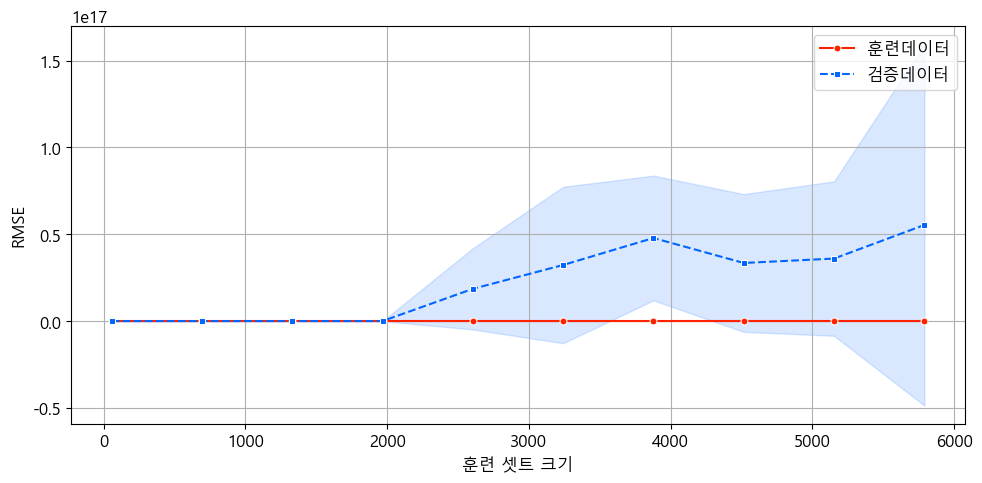

In [38]:
train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1) 
test_std = -np.std(test_scores, axis=1)

plt.figure(figsize=(10, 5), dpi=100)

# 훈련 데이터 수에 따른 훈련 데이터의 score 평균
sb.lineplot(x=train_sizes, y=train_mean,  marker='o', markersize=5, label='훈련데이터', color='#ff2200')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='#ff2200')

# 검증 데이터 수에 따른 검증 데이터의 score 평균
sb.lineplot(x=train_sizes, y=test_mean, linestyle='--', marker='s', markersize=5, label='검증데이터', color='#0066ff')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='#0066ff')

plt.grid()
plt.xlabel('훈련 셋트 크기')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()